In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


In [10]:
# 导入预训练好的VGG16网络
vgg16=models.vgg16(pretrained=True)
# 获取VGG16的特征提取层
vgg=vgg16.features
# 将VGG16的特征提取层参数冻结，不对其进行更新
for param in vgg.parameters():
    param.requires_grad_(False)
        

In [11]:
# 使用VGG16的特征提取层＋新的全连接层组成新的网络
class MyVggModel(nn.Module):
    def __init__(self):
        super(MyVggModel,self).__init__()
        # 预训练的VGG16的特征提取层
        self.vgg=vgg
        # 添加新的全连接层
        self.classifier=nn.Sequential(
            nn.Linear(25088,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256,10),
            nn.Softmax(dim=1)
        )
    # 定义网络的前向传播路径
    def forward(self,x):
        x=self.vgg(x)
        x=x.view(x.size(0),-1)
        output=self.classifier(x)
        return output

In [12]:
# 输出网络结构
Myvggc=MyVggModel()
print(Myvggc)

MyVggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [13]:
# 使用10类猴子的数据集，对数据集预处理
train_data_transforms=transforms.Compose([
    transforms.RandomResizedCrop(224),# 随机长宽比裁剪为224*224
    transforms.RandomHorizontalFlip(),# 依照概率p=0.5水平翻转
    transforms.ToTensor(),# 转化为张量并归一化到[0-1]
    # 图像标准化处理
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
# 对验证集的预处理
val_data_transforms=transforms.Compose([
    transforms.Resize(256),# 重置图像分辨率
    transforms.CenterCrop(224),# 一句给定的size从中心裁剪
    transforms.ToTensor(),# 转化为张量并归一化至[0-1]
    # 图像标准化处理
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

In [14]:
# 读取训练集图像
trian_data_dir="data/chap6/10-monkey-species/training"
train_data=ImageFolder(trian_data_dir,transform=train_data_transforms)
train_data_loader=Data.DataLoader(train_data,batch_size=32,shuffle=True,num_workers=2)
# 读取验证集
val_data_dir="data/chap6/10-monkey-species/validation"
val_data=ImageFolder(val_data_dir,transform=val_data_transforms)
val_data_loader=Data.DataLoader(val_data,batch_size=32,shuffle=True,num_workers=2)
print("训练集样本数:",len(train_data.targets))
print("验证集样本数:",len(val_data.targets))


训练集样本数: 1097
验证集样本数: 272


True


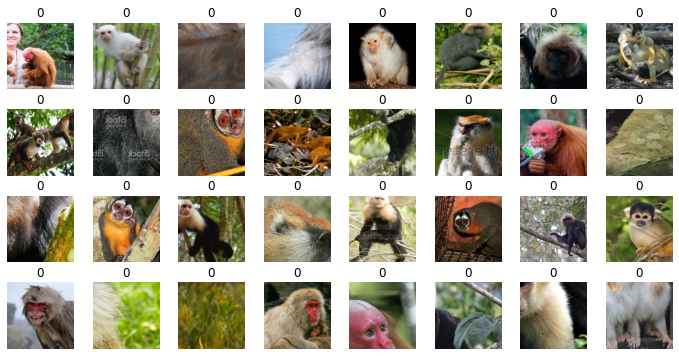

In [15]:
# 获取一个batch的数据
for step,(b_x,b_y) in enumerate(train_data_loader):
    if step>0:
        break
# 可视化训练集其中一个batch的图像
mean=np.array([0.485,0.456,0.406])
std=np.array([0.229,0.224,0.225])
plt.figure(figsize=(12,6))
for ii in np.arange(len(b_y)):
    plt.subplot(4,8,ii+1)
    image=b_x[ii,:,:,:].numpy().transpose((1,2,0))
    image=std*image+mean
    image=np.clip(image,0,1)
    plt.imshow(image)
    plt.title(b_y[ii].data.numpy())
    plt.axis("off")
plt.subplots_adjust(hspace=0.3)
print(not(np.any(b_y[ii].data.numpy())))

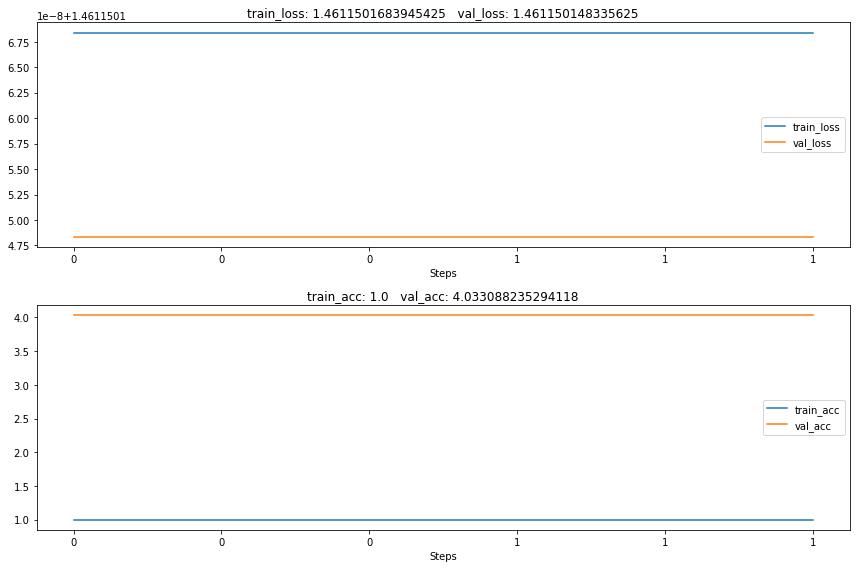

KeyboardInterrupt: 

In [20]:
# 定义优化器
optimizer=torch.optim.Adam(Myvggc.parameters(),lr=0.003)
loss_func=nn.CrossEntropyLoss() # 损失函数，交叉熵
# 记录训练过程的指标
history1=hl.History()
# 使用Canvas进行可视化
canvasl=hl.Canvas()
# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(10):
    train_loss_epoch=0
    val_loss_epoch=0
    train_corrects=0
    val_corrects=0
    # 对训练数据的加载器进行迭代计算
    Myvggc.train()
    for step,(b_x,b_y) in enumerate(train_data_loader):
        # 计算每一个batch的损失
        output=Myvggc(b_x) # CNN在训练batch上的输出
        loss=loss_func(output,b_y)
        pre_lab=torch.argmax(output,1)
        optimizer.zero_grad() # a每个迭代步的梯度初始化为0
        loss.backward()# 损失的后向传播，计算梯度
        optimizer.step()# 使用梯度进行优化
        train_loss_epoch+=loss.item()*b_x.size(0)
        train_corrects+=torch.sum(pre_lab==b_y.data)
    # 计算一个epoch的损失和精度
    train_loss=train_loss_epoch/len(train_data.targets)
    train_acc=train_corrects.double()/len(train_data.targets)
    # 计算在验证集上的表现
    Myvggc.eval()
    for step,(val_x,val_y) in enumerate(val_data_loader):
        output=Myvggc(val_x)
        loss=loss_func(output,val_y)
        pre_lab=torch.argmax(output,1)
        val_loss_epoch+=loss.item()*val_x.size(0)
        val_corrects+=torch.sum(pre_lab==val_y.data)
    # 计算一个epoch1的损失和精度
    val_loss=val_loss_epoch/len(val_data.targets)
    val_acc=train_corrects.double()/len(val_data.targets)
    # 保存每个epoch上的输出loss和acc
    history1.log(epoch,train_loss=train_loss
    ,val_loss=val_loss,
    train_acc=train_acc.item(),
    val_acc=val_acc.item())
    # 可视化网络训练的过程
    with canvasl:
        canvasl.draw_plot([history1["train_loss"],history1["val_loss"]])
        canvasl.draw_plot([history1["train_acc"],history1["val_acc"]])

